DIABETES RETINOPATHY DETECTION USING PYTHON

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pywt
from math import sqrt, pi, exp
from matplotlib import cm
import csv

In [2]:
immatrix = []
im_unpre = []

for i in range(0, 120):
    img_pt = r"Images\\"
    img_pt = img_pt + str(i+1) + ".png"
    img = cv2.imread(img_pt)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(img_gray)
    immatrix.append(np.array(equ).flatten())

In [3]:
np.shape(np.array(equ).flatten())

(3050208,)

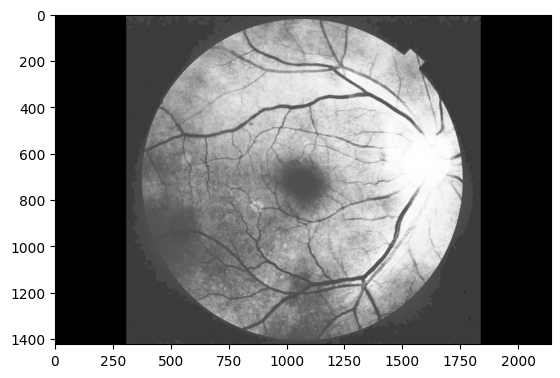

In [4]:
np.shape(immatrix)
np.shape(equ)
plt.imshow(immatrix[1].reshape((1424, 2142)), cmap='gray')
plt.show()

Performing Discrete_Wavelet transform on the 2-D array available

In [5]:
imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((1424, 2142))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())

Visualising a random image

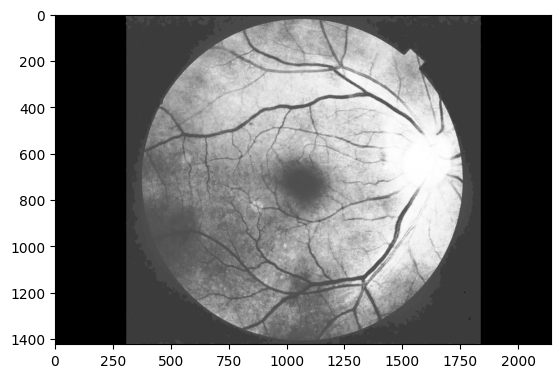

In [6]:
np.shape(imm_dwt)
plt.imshow(imm_dwt[1].reshape((1424, 2142)), cmap='gray')
plt.show()

In [44]:
def show_images(images, titles=None, scale=1.3):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)  # Make subplot
        if image.ndim == 2:  # Is image grayscale?
            plt.imshow(image, cmap=cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()

In [45]:
def _filter_kernel_mf_fdog(L, sigma, t=3, mf=True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')

    ctr_x = dim_x / 2
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate.
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)
    
    vectorized_k_fun = np.vectorize(k_fun, otypes=[np.float32])
    vectorized_k_fun_derivative = np.vectorize(k_fun_derivative, otypes=[np.float32])

    if mf:
        kernel = vectorized_k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = vectorized_k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1)


In [46]:
def gaussian_matched_filter_kernel(L, sigma, t=3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)

In [47]:
def createMatchedFilterBank(K, n=12):
    '''
    Given a kernel, create matched filter bank
    '''
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

In [48]:
def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

In [49]:
gf = gaussian_matched_filter_kernel(15, 5)
bank_gf = createMatchedFilterBank(gf, 4)

imm_gauss = []
for equ2 in immatrix:
    equ2 = equ2.reshape((1424, 2142))
    equ3 = applyFilters(equ2, bank_gf)
    imm_gauss.append(np.array(equ3).flatten())


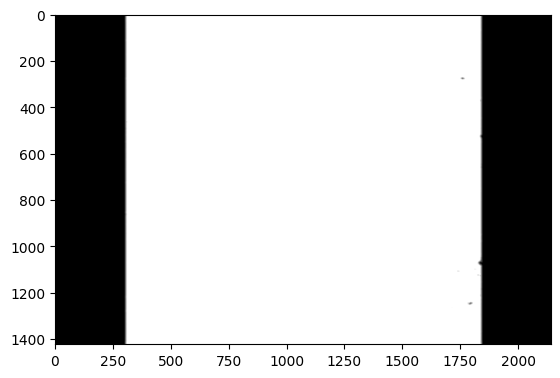

In [50]:
np.shape(imm_gauss)
plt.imshow(imm_gauss[0].reshape((1424, 2142)), cmap='gray')
plt.show()

In [14]:
def createMatchedFilterBank():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel(
            (ksize, ksize), 6, theta, 12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters


def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)


bank_gf = createMatchedFilterBank()

imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((1424, 2142))
    equ3 = applyFilters(equ2, bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())


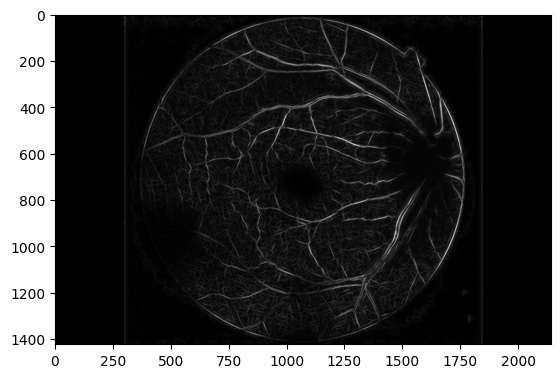

In [15]:
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[1].reshape((1424, 2142)), cmap='gray')
plt.show()

K-Mean Clusttering with PP centers

In [16]:
img = equ3
Z = img.reshape((-1, 3))

# convert to np.float32
Z = np.float32(Z)

k = cv2.KMEANS_PP_CENTERS

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, k)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))


In [17]:
imm_kmean = []
for equ3 in imm_gauss2:
    img = equ3.reshape((1424, 2142))
    Z = img.reshape((-1, 3))

    # convert to np.float32
    Z = np.float32(Z)
    k = cv2.KMEANS_PP_CENTERS

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())

In [18]:
# imm_kmean = []

# # Define the number of clusters (K)
# K = 2

# # Define the criteria for k-means
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 2)

# # Loop over the images in imm_gauss2
# for equ3 in imm_gauss2:
#     # Reshape the image to the desired shape (1424, 2142)
#     img = equ3.reshape((1424, 2142))

#     # Convert the image to np.float32
#     Z = np.float32(img)

#     # Apply k-means clustering
#     _, label, center = cv2.kmeans(Z.reshape(-1, 4), K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

#     # Convert center values to uint8
#     center = np.uint8(center)

#     # Map the labels to the center values
#     res = center[label.flatten()]

#     # Reshape the result to the original image shape
#     res2 = res.reshape(img.shape)

#     # Flatten the processed image and append it to imm_kmean
#     imm_kmean.append(res2.flatten())


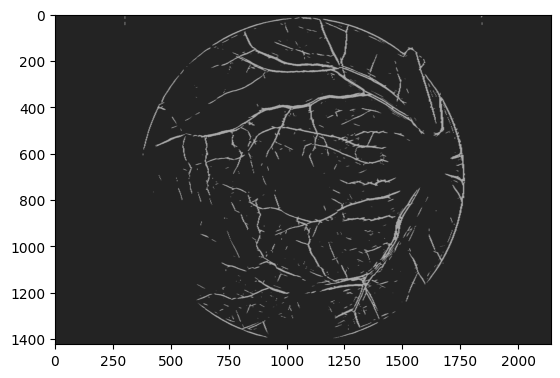

In [19]:
np.shape(imm_kmean)
plt.imshow(imm_kmean[1].reshape((1424, 2142)), cmap="gray")
plt.show()

In [20]:
dataset = pd.read_csv('D:\Diabetes_ML model\Images\Training Set.csv')
Y = dataset.iloc[0:120, -1].values

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imm_kmean, Y, test_size=0.20, random_state=0)

In [22]:
print(X_train)

[array([24, 22, 24, ..., 24, 22, 24], dtype=uint8), array([5, 3, 5, ..., 5, 3, 5], dtype=uint8), array([235, 231, 235, ..., 235, 231, 235], dtype=uint8), array([41, 37, 41, ..., 41, 37, 41], dtype=uint8), array([254, 252, 254, ..., 254, 252, 254], dtype=uint8), array([15, 12, 15, ..., 15, 12, 15], dtype=uint8), array([225, 222, 225, ..., 225, 222, 225], dtype=uint8), array([213, 212, 213, ..., 213, 212, 213], dtype=uint8), array([33, 30, 33, ..., 33, 30, 33], dtype=uint8), array([18, 16, 18, ..., 18, 16, 18], dtype=uint8), array([69, 66, 69, ..., 69, 66, 69], dtype=uint8), array([82, 78, 82, ..., 82, 78, 82], dtype=uint8), array([23, 20, 23, ..., 23, 20, 23], dtype=uint8), array([219, 214, 219, ..., 219, 214, 219], dtype=uint8), array([31, 29, 31, ..., 31, 29, 31], dtype=uint8), array([51, 49, 51, ..., 51, 49, 51], dtype=uint8), array([211, 207, 211, ..., 211, 207, 211], dtype=uint8), array([245, 242, 245, ..., 245, 242, 245], dtype=uint8), array([11,  9, 11, ..., 11,  9, 11], dtype=ui

In [23]:
print(X_test)

[array([39, 35, 39, ..., 39, 35, 39], dtype=uint8), array([245, 243, 245, ..., 245, 243, 245], dtype=uint8), array([50, 47, 50, ..., 50, 47, 50], dtype=uint8), array([254, 252, 254, ..., 254, 252, 254], dtype=uint8), array([29, 26, 29, ..., 29, 26, 29], dtype=uint8), array([23, 20, 23, ..., 23, 20, 23], dtype=uint8), array([239, 238, 239, ..., 239, 238, 239], dtype=uint8), array([212, 210, 212, ..., 212, 210, 212], dtype=uint8), array([182, 179, 182, ..., 182, 179, 182], dtype=uint8), array([57, 53, 57, ..., 57, 53, 57], dtype=uint8), array([191, 186, 191, ..., 191, 186, 191], dtype=uint8), array([233, 231, 233, ..., 233, 231, 233], dtype=uint8), array([180, 177, 180, ..., 180, 177, 180], dtype=uint8), array([252, 250, 252, ..., 252, 250, 252], dtype=uint8), array([7, 4, 7, ..., 7, 4, 7], dtype=uint8), array([27, 24, 27, ..., 27, 24, 27], dtype=uint8), array([221, 217, 221, ..., 221, 217, 221], dtype=uint8), array([10,  8, 10, ..., 10,  8, 10], dtype=uint8), array([24, 22, 24, ..., 24,

In [24]:
print(y_test)

[1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0]


In [25]:
print(y_train)

[0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0
 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1]


MODEL TRAINING (Kernel SVC)

In [26]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [27]:
from sklearn.svm import SVC
classifier = SVC()

In [51]:
classifier.fit(imm_kmean, Y)

SVC()

In [52]:
y_pred = classifier.predict(imm_kmean)
print(np.concatenate((y_pred.reshape(len(y_pred),1), Y.reshape(len(Y),1)),1))

[[1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [0 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [1 0]
 [1 1]
 [1 0]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [0 1]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 1]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [0 1]
 [1 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 0]
 [1 0]
 [0 0]
 [1 0]
 [0 0]
 [1 0]]


In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(Y, y_pred)
print(cm)
accuracy_score(Y, y_pred)

[[31 29]
 [12 48]]


0.6583333333333333

MODEL TRAINING (KNN)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [54]:
neigh = KNeighborsClassifier(n_neighbors = 3)

In [55]:
neigh.fit(imm_kmean, Y)

KNeighborsClassifier(n_neighbors=3)

In [56]:
y_pred2 = neigh.predict(imm_kmean)
print(np.concatenate((y_pred2.reshape(len(y_pred2),1), Y.reshape(len(Y),1)),1))

[[1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [0 1]
 [1 1]
 [0 1]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [0 1]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


In [57]:
cm = confusion_matrix(Y, y_pred2)
print(cm)
accuracy_score(Y, y_pred2)

[[41 19]
 [12 48]]


0.7416666666666667

MODEL TRAINING (Random Forest)

In [58]:
from sklearn.ensemble import RandomForestClassifier
classifier1 = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
classifier1.fit(imm_kmean, Y)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [59]:
y_pred3 = classifier1.predict(imm_kmean)
print(np.concatenate((y_pred3.reshape(len(y_pred3),1), Y.reshape(len(Y),1)),1))

[[1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [0 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


In [60]:
cm = confusion_matrix(Y, y_pred3)
print(cm)
accuracy_score(Y, y_pred3)

[[60  0]
 [ 8 52]]


0.9333333333333333

MODEL TRAINING(CNN)